# Hands-On Classification 

For this hands-on session, let us go back to the signal processing aspects.
Let us show again the block-diagram of the project. The very first hands-on session was focused on computing the feature vector from a sound vector. 
Here, we are going to insert a simple classification model in our chain. This is the core of our application. <br>

<center> <img src="figs/block-diagram.png" alt=""  width="650" height="350"/> </center>

There exists a lot of different classification models in the literature. In this notebook we propose to play with two simple and intuitive classifiers: the K-Nearest-Neighbour (``KNN``) classifier and the Linear Discriminant Analysis (``LDA``) classifier. The related Wikipedia page are [KNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) and [LDA](https://en.wikipedia.org/wiki/Linear_discriminant_analysis). <br>
Made simple, KNN and LDA are ``supervised machine learning algorithms``. For KNN, each new point to be classified is compared with its K nearest neighbours among labelled data (i.e. points whose class is known) in the dataspace with respect to a chosen distance metric. For LDA, the data distributions of the classes are assumed to be normal, i.i.d. and with the same covariance. The decision boundaries are set to areas in the distribution space where the log-likelihood that the data belongs to another class is higher than the true class. It is worth noticing that the LDA classifier is a parametric model while KNN is not. Indeed, KNN has only one hyperparameter $K$, but the learning phase simply consist of saving the learning set in memory to be used later for inference.  <br>

To avoid reinventing the wheel, we will use the implementations provided by ``sklearn``. You are strongly encouraged to have a look at the documentation [for the KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) and [for the LDA](https://scikit-learn.org/stable/modules/lda_qda.html?highlight=lda). We will also use ``pickle`` for saving and loading the trained models. <br>
<!-- In case of an error with the utils folder (folder not found), you may need to launch Jupyter with the directory where the code to execute is located. To do so, open the Anaconda Prompt (if you are using Anaconda) and type ``jupyter notebook --notebook-dir=$YOUR PATH$``. <br> -->
Useful functions to select, read and play the dataset sounds are provided in ``src/classification``. <br>

As for the first hands-on session of the semester ``hands_on_feature_vectors.ipynb`` (written ``H1`` below for compactness), you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

In [3]:
### TO RUN
import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from classification.utils.plots import plot_decision_boundaries, show_confusion_matrix
from classification.utils.utils import accuracy

<font size=6 color=#009999> 1. Getting intuition with a toy example [~1h-1h30] </font> <br>

Before going deep into classifying the complicated feature vectors we designed in H1, let us analyze a toy example. <br>
It is always good practice to make some trials on a simplified version of a problem before tackling it. It prevents from a big amount of time loss and some strange dark bugs. <br>

The convention used by ``sklearn`` is that $\boldsymbol{X}$ is a matrix whose height is the number $N$ of samples in the dataset and width is the dimension $p$ of each feature vector, as depicted here below (one colour is one class). It writes 
\begin{equation*}
    \boldsymbol X = (\boldsymbol x_1, \cdots, \boldsymbol x_N)^\top
\end{equation*}

with $\boldsymbol x_i \in \mathbb R^p$ the feature vector of the $i$-th sample whose class is encoded in $y_i$, i.e. 
\begin{equation*}
    y_i \in \{\text{'Class 0'}, \cdots, \text{'Class 3'}\}
\end{equation*}

<center> <img src="figs/Xy.svg" alt=""  width="500"/> </center>

<font size=5 color=#009999> 1.0. Generating data for the toy example </font> <br>

Beware, the points are plotted in 2D but can belong to a space with more dimensions!


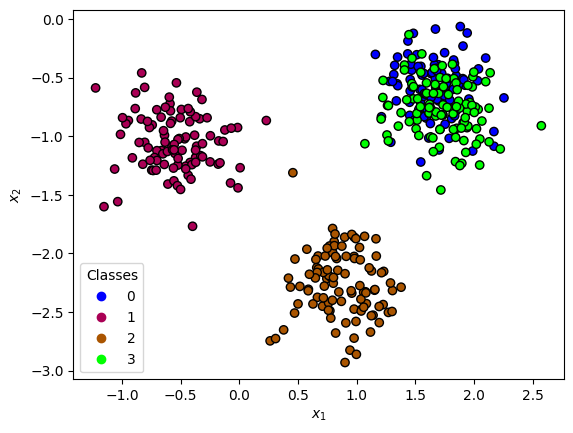

In [4]:
### TO RUN
plot3D = False
normalize = False
N = 100  # Number of points per subcluster. (defaut: 100)
n_classes = 4  # Number of differents classes. (default: 4)
n_subclusters = 1  # Number of subclusters of points per class. (defaut: 1)
dim = 2  # Dimensionality of the point clouds. (defaut: 2)
dim_clusters = 2  # Dimensionality of the clusters arrangment. (default: 2)
sig = 0.25  # Noise std. (default: 0.25)
np.random.seed(
    1
)  # For some reproducibility in the results, you can change the seed or remove this line if desired. (default: 1)

M = N * n_subclusters  # Number of points per class

"Generate the data"
cluster_centers = np.concatenate(
    (
        np.random.randn(n_classes * n_subclusters, dim_clusters),
        np.zeros((n_classes * n_subclusters, dim - dim_clusters)),
    ),
    axis=1,
)
centers = np.repeat(cluster_centers, N, axis=0)
noise = sig * np.random.randn(n_classes * M, dim)
X = centers + noise
if normalize:
    X /= np.linalg.norm(X, axis=1, keepdims=True)
y = np.repeat(np.arange(n_classes), M)

print(
    "Beware, the points are plotted in 2D but can belong to a space with more dimensions!"
)

"Plot"
cm = "brg"
edgc = "k"
fig = plt.figure()
if plot3D:
    ax = plt.axes(projection="3d")
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=cm, edgecolor=edgc)
else:
    ax = plt.gca()
    ax.set_aspect("equal", adjustable="box")
    scatterd = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm, edgecolors=edgc)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
handles, labels = scatterd.legend_elements(prop="colors")
ax.legend(handles, labels, title="Classes")
plt.show()

<font size=5 color=#009999> 1.1. Metrics and model evaluation </font> <br>
In order to objectively evaluate the performance of your classification model, the use of metrics is necessary.
[See some examples here.](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226) <br>
Throughout this notebook and for this project, the two metrics we will use are:
* Accuracy = $\frac{\text{\# Good predictions}}{\text{Total \# predictions}} = \frac{\text{TP+TN}}{\text{TP+FP+FN+TN}}$.
* Confusion matrix: add $1$ to the counter at position $(i,j)$ if the model predicted $i$ but the true label was $j$.

If you are interested, there exists a lot of other metrics. Checkout on the internet. <br>

We provide the code for the KNN classifier. For you to start handling sklearn implementations, we let you ``declare a LDA classifier and compute its accuracy on the test set``.

Accuracy KNN : 79.17 %
Accuracy LDA : 81.67 %


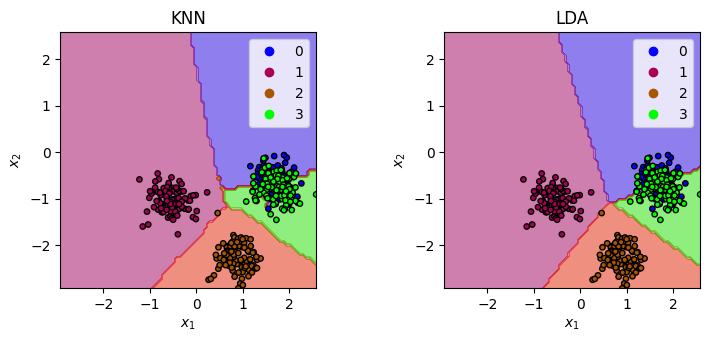

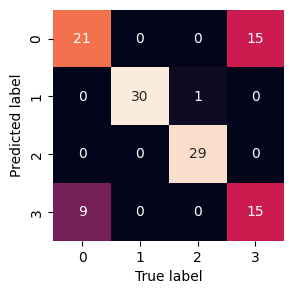

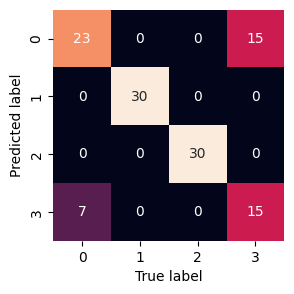

In [6]:
"Shuffle the data then split in training and testing sets"
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)  # 'stratify=y' ensures we pick the same number of samples per class during the splitting

K = 10  # Number of neighbours
model_knn = KNeighborsClassifier(n_neighbors=K)  # Declare the KNN classifier
model_knn.fit(X_train, y_train)  # Train the classifier
prediction_knn = model_knn.predict(X_test)
accuracy_knn = np.sum(prediction_knn - y_test == 0) / X_test.shape[0]
print(f"Accuracy KNN : {100 * accuracy_knn:.2f} %")

### TO COMPLETE
# Declare and train an LDA classifier, then evaluate on the test set
model_lda = LDA()  # Linear Discriminant Analysis with default parameters
model_lda.fit(X_train, y_train)
prediction_lda = model_lda.predict(X_test)
accuracy_lda = np.sum(prediction_lda == y_test) / X_test.shape[0]
print(f"Accuracy LDA : {100 * accuracy_lda:.2f} %")

"Plot"
if dim == 2:
    # Plot the decision boundary.
    s = 15.0
    fig = plt.figure()
    axs = [fig.add_axes([0.0, 0.0, 0.4, 0.9]), fig.add_axes([0.6, 0.0, 0.4, 0.9])]
    plot_decision_boundaries(
        X, y, model_knn, ax=axs[0], legend=labels, title="KNN", s=s
    )
    plot_decision_boundaries(
        X, y, model_lda, ax=axs[1], legend=labels, title="LDA", s=s
    )
    # plt.show()

axs[0].set_title("KNN")
show_confusion_matrix(prediction_knn, y_test, np.arange(n_classes))
axs[1].set_title("LDA using rbf kernel")
show_confusion_matrix(prediction_lda, y_test, np.arange(n_classes))

## It's already time for some analysis (put the default parameters when unspecified):
### 1) Which accuracy would you expect from a classifier choosing uniformly at random?
P(chossing the correct class) = $\frac{1}{n_{classes}}$
 

### 2) Can you explain why the classifiers are more confused between classes 0 and 3?
Looking at the graphs we see that 0 and 3rd group is almost at the same position

### 3) Play with n_classes, how do the accuracy and the confusion matrix evolve with it?
When we increase n_classes, Accuracy decreases

### 4) Play with sig, how do the accuracy and the confusion matrix evolve with it?
When sig increases : - Accuracy decrease for both - Difference between Accuracy of KNN and LAD increases => LAD performs better in noisy data

### 5) Fix dim=20, do you observe any change? An intuitive explanation?
Accuracy = 79.17(KNN) et 80.83(LDA) Centers of clusters are still computed in 2D

### 6) Fix dim=20 and dim_clusters=20, what do you observe?
Accuracy goes to 100% adding dimensions allow us to differentiater better the cluster (centers are computed not only in 2D with 0 for every other coordinate)

### 7) Change K to 200, what is the impact on the confusion matrix? Now choose n_subclusters=2, what happens?
i - As K=200 there is a lot of confusion between (2,0) and (2,3) ii - n_subclusters = 2 + K=200 : Confusion between (1,2) and (1,3)

### 8) How different are the decision boundaries between the KNN and the LDA with linear kernels? Which one would work best on the 3-ringes data example provided at the end of this notebook(come back to this question later)?

### 9) Put normalize=True. What do you observe in the data distribution? Think of the data points as if it corresponded to the acquired sounds. In which situation is it interesting to normalize?
It puts every point on circle of unit rayon. It can be usefull to compare audio feature that has many different magnitudes

In [ ]:
### TO COMPLETE
# Answer the questions above

<font size=5 color=#009999> 1.2. Dataset splitting and Model choice </font> <br>

The usual convention to objectively analyse the performances of learned models is to split the dataset into three sets: ``learning, validation, testing`` where the validation set allows to choose the hyperparameters of each model. 

<center> <img src="figs/dataset_splitting.svg" alt=""  width="500" height="250"/> </center>

All the data in the learning and validation sets is used to train models and choose the hyperparameters that are optimal with respect to the chosen metrics, we call the ensemble the ``training set``. 
When training a model and comparing different settings, there is a risk that we will end up choosing optimal parameters that only renders good result on our specific case of training and validation set, but ``do not generalize well for additional data``. This is called ``overfitting on the validation set``. To alleviate this, we can perform ``cross-validation (CV)``. A basic approach named ``K-fold CV`` involves partitioning the dataset in ``K`` "folds" (subsets) and repetitvely do the following procedure:

- Train the model using `K-1` folds as the training data.
- Test the model using the last fold as the validation data.

The overall performance on each fold is then averaged to obtain the final performance metrics.
Alternatives to K-fold CV like [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) or other techniques exist.

In [7]:
### TO RUN
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)

accuracy_knn = np.zeros((n_splits,))
accuracy_lda = np.zeros((n_splits,))
for k, idx in enumerate(kf.split(X_train, y_train)):
    (idx_learn, idx_val) = idx
    model_knn.fit(X_train[idx_learn], y_train[idx_learn])
    prediction_knn = model_knn.predict(X_train[idx_val])
    accuracy_knn[k] = accuracy(prediction_knn, y_train[idx_val])

    model_lda.fit(X_train[idx_learn], y_train[idx_learn])
    prediction_lda = model_lda.predict(X_train[idx_val])
    accuracy_lda[k] = accuracy(prediction_lda, y_train[idx_val])

print(f"Mean accuracy of KNN with {n_splits}-Fold CV: {100 * accuracy_knn.mean():.1f}%")
print(
    f"Std deviation in accuracy of KNN with 5-Fold CV: {100 * accuracy_knn.std():.1f}% \n"
)
print(f"Mean accuracy of LDA with {n_splits}-Fold CV: {100 * accuracy_lda.mean():.1f}%")
print(
    f"Std deviation in accuracy of LDA with 5-Fold CV: {100 * accuracy_lda.std():.1f}%"
)

Mean accuracy of KNN with 5-Fold CV: 80.4%
Std deviation in accuracy of KNN with 5-Fold CV: 2.3% 

Mean accuracy of LDA with 5-Fold CV: 82.5%
Std deviation in accuracy of LDA with 5-Fold CV: 2.9%


In the upper analysis, we fixed ``K`` for the KNN. This is called an ``hyperparameter`` of the classification model. Let us now have a look at the effect of this hyperparameter!  

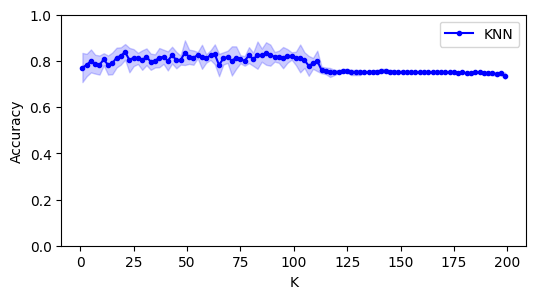

In [8]:
### TO RUN
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)

Ks = np.arange(1, 200, 2)
accuracies_knn = np.zeros((len(Ks), n_splits))
for i, K in enumerate(Ks):
    model_knn = KNeighborsClassifier(n_neighbors=K)
    for k, idx in enumerate(kf.split(X_train, y_train)):
        (idx_learn, idx_val) = idx
        model_knn.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_knn = model_knn.predict(X_train[idx_val])
        accuracies_knn[i, k] = accuracy(prediction_knn, y_train[idx_val])
means_knn = accuracies_knn.mean(axis=1)
stds_knn = accuracies_knn.std(axis=1)

"Plot"
plt.figure(figsize=(6, 3))

plt.plot(Ks, means_knn, ".-b", label="KNN")
plt.fill_between(Ks, means_knn - stds_knn, means_knn + stds_knn, alpha=0.2, color="b")
plt.ylim(0, 1)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Question:

- What do you conclude regarding the dependency of the accuracy on K for the KNN in this case? Does it hold for other sets of parameters for the data generation? Comment.

When K is over 100 the accuracy flatten a lot more and if we just change the parameters of generation of dimension for instance, Ks give a perfect accuracy until 110 then it worsen.

Now that we analysed the performance dependence on the hyperparameters, we can compare the two selected models on the ``test`` set.

In [9]:
### TO RUN
best_K = Ks[np.argmax(means_knn)]

print(f"Best K for KNN: {best_K}")

model_best_knn = KNeighborsClassifier(n_neighbors=best_K)
model_best_knn.fit(X_train, y_train)
prediction_best_knn = model_best_knn.predict(X_test)
accuracy_best_knn = accuracy(prediction_best_knn, y_test)
print(f"Accuracy best KNN : {100 * accuracy_best_knn:.2f} %")

model_lda = LDA()
model_lda.fit(X_train, y_train)
prediction_lda = model_lda.predict(X_test)
accuracy_lda = accuracy(prediction_lda, y_test)
print(f"Accuracy LDA : {100 * accuracy_lda:.2f} %")

Best K for KNN: 21
Accuracy best KNN : 83.33 %
Accuracy LDA : 81.67 %


### Question:
- From the output here above, which model will you choose at the end?

From what we've seen so far, LDA is likely to perform better when the data is linearly separable and when the number of features is not excessively high compared to the number of samples. KNN, on the other hand, can adapt better to more complex decision boundaries but may suffer from the curse of dimensionality as the feature space increases. So we prefer KNN for more complex data

<font size=5 color=#009999> Comment </font> <br>

``You don't have to understand the code.`` <br>

It can happen that the data to be classified is exploitable, but non linearly separable in their ambient space. It can be smart to find a transformation function $\Phi (\boldsymbol X)$
that would ease the discrimination between your data points. For example, this is the trick used in [SVM](https://scikit-learn.org/stable/modules/svm.html) when radial basis functions or polynomial kernels are used (not shown here). Run the code here below and observe how well we are able to transform three intricate rings of data points into three localised point clouds using a technique called *spectral clustering*. 

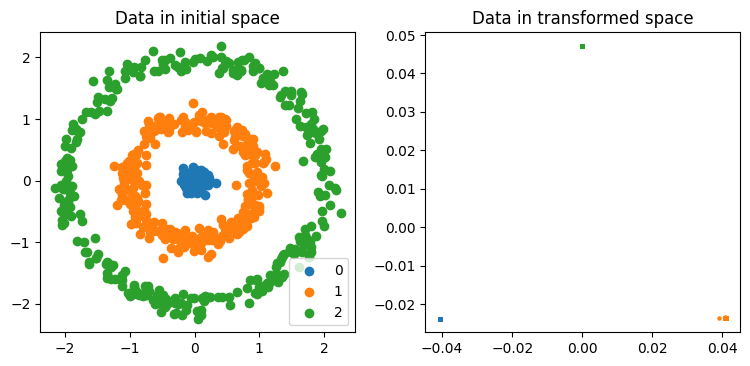

In [11]:
### TO RUN
N = 300  # Number of points per subcluster. (defaut: 100)
n_classes = 3
M = n_classes * N
thetas = np.random.uniform(0, 2 * np.pi, M)

X2 = (
    (np.array([np.cos(thetas), np.sin(thetas)]))
    * (np.arange(M) // N + 0.1 * np.random.randn(M))
).T  # The data points

sigma = 0.1
W = np.zeros((M, M))
for i in range(M):
    for j in range(i):
        dist = (
            np.linalg.norm(X2[i, :] - X2[j, :]) ** 2
        )  # Should decrease with the distance!
        W[i, j] = np.exp(-dist / (2 * sigma**2))
        W[j, i] = np.exp(-dist / (2 * sigma**2))

D = np.diag(np.sum(W, axis=0))  # Degree matrix for a weigthed graph
L = D - W  # Graph Laplacian
(U, s, _) = np.linalg.svd(L, full_matrices=True)  # SVD decomposition of L

# Keep only K first eigenvectors
K = 3
# Careful: SVD returns the singular values in DESCENDING order; we thus want to extract the LAST two columns
U = U[:, -K:]

fig = plt.figure(figsize=(7, 3))
axs = [fig.add_axes([0.55 * i, 0, 0.45, 1]) for i in range(2)]
for i in range(n_classes):
    axs[0].scatter(X2[i * N : (i + 1) * N, 0], X2[i * N : (i + 1) * N, 1], label=i)
    axs[1].scatter(U[i * N : (i + 1) * N, 0], U[i * N : (i + 1) * N, 1], s=5)
axs[0].legend()
axs[0].set_title("Data in initial space")
axs[1].set_title("Data in transformed space")
plt.show()

<font size=5 color=#009999> 1.3. Dimensionality reduction </font> <br>

It is sometimes good practice to reduce the dimensionality of a signal in order to get the main components of their distribution. A motivation is that usual norms behave counter-inuitively in high dimension. To reduce the dimensionality, we will use the ``Principal compenent analysis (PCA)`` proposed by sklearn. See the [associated Wikipedia page](https://en.wikipedia.org/wiki/Principal_component_analysis). We start by illustrating the interest of PCA with a toy example.

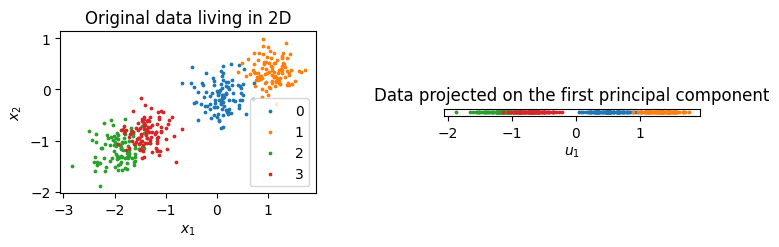

In [12]:
### TO RUN
N = 100  # Number of points per subcluster. (defaut: 100)
n_classes = 4  # Number of differents classes. (default: 4)
sig = 0.25  # Noise std. (default: 0.25)
np.random.seed(
    8
)  # For some reproducibility in the results, you can change the seed or remove this line if desired. (default: 1)

"Generate the data"
xc = np.random.randn(n_classes)
yc = 0.5 * xc - 0.2
cluster_centers = np.concatenate((xc[:, np.newaxis], yc[:, np.newaxis]), axis=1)
centers = np.repeat(cluster_centers, N, axis=0)
noise = sig * np.random.randn(n_classes * N, 2)
X = centers + noise

"Apply PCA on data to reduce dimensionality to 1D"
n = 1  # Number of principal components kept
pca = PCA(n_components=n, whiten=True)
X_reduced = pca.fit_transform(X)

"Plot"
s = 3.0
fig = plt.figure()
axs = [fig.add_axes([0.0, 0.0, 0.4, 1.0]), fig.add_axes([0.6, 0.0, 0.4, 1.0])]
axs[0].set_aspect("equal", adjustable="box")
axs[1].set_aspect("equal", adjustable="box")
for i in range(n_classes):
    axs[0].scatter(X[i * N : (i + 1) * N, 0], X[i * N : (i + 1) * N, 1], label=i, s=s)
    axs[1].scatter(X_reduced[i * N : (i + 1) * N], np.zeros(N), label=i, s=s)
axs[0].set_title("Original data living in 2D")
axs[1].set_title("Data projected on the first principal component")
axs[0].set_xlabel("$x_1$")
axs[0].set_ylabel("$x_2$")
axs[1].set_xlabel("$u_1$")
axs[1].set_yticks([])
axs[0].legend()
plt.show()

This hands-on session focuses on the simple KNN and LDA classifiers. However, there are many other that are worth giving a try using SKlearn. To give you motivation, run ``plot_classifier_comparison.py``

Gaussian process is overall the best maybe try this one for our projec